In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('Amazon_Historical_StockPrice2.csv',parse_dates=['Date'], index_col='Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400
...,...,...,...,...,...,...
2021-03-22,3067.850098,3126.580078,3060.050049,3110.870117,3110.870117,2902200
2021-03-23,3127.000000,3182.000000,3120.850098,3137.500000,3137.500000,3817300
2021-03-24,3151.040039,3160.310059,3085.149902,3087.070068,3087.070068,2959000


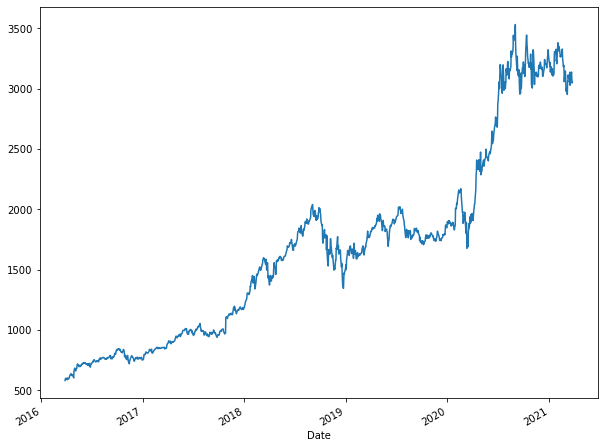

In [2]:
df.Close.plot(figsize=(10, 8))

AttributeError: module 'statsmodels' has no attribute 'tsa'

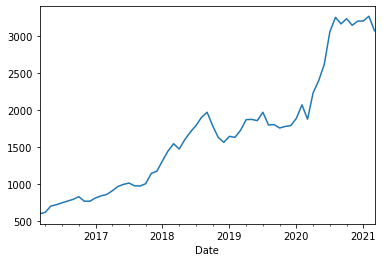

In [3]:
df_month = df.Close.resample('M').mean()
df_month.plot()
df_week = df.Close.resample('W').mean()

import statsmodels
statsmodels.tsa.stattools.adfuller(df_month.values)[1]

Seasonal_decompose


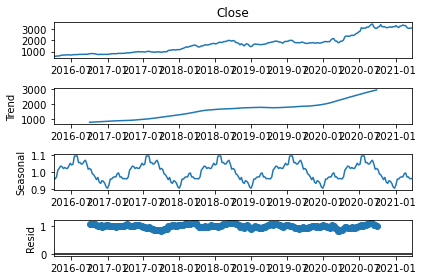

STL


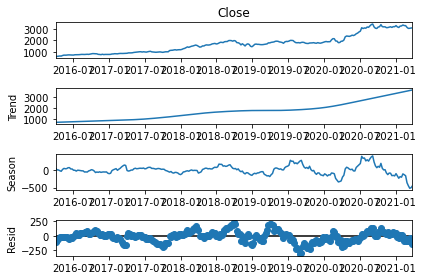

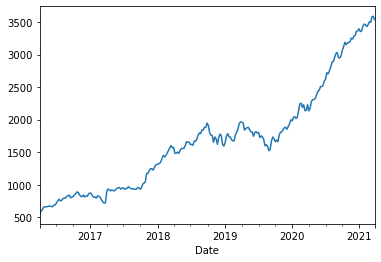

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
print("Seasonal_decompose")
result = seasonal_decompose(df_week, model='multiplicative')
result.plot()
plt.show()
print("STL")
stl = STL(df_week,seasonal= 11).fit()
stl.plot()
plt.show()
df_week_ns = stl.trend+stl.resid
df_week_ns.plot()
plt.show()

In [5]:
from pmdarima.arima import auto_arima
df_week.shape

(261,)

In [6]:
from scipy.special import boxcox, inv_boxcox
model = auto_arima(boxcox(df_week_ns[:200], -0.4), start_p=0, start_q=0, test='adf', max_d=4, max_q=4, m=1,
           start_P=0, seasonal=True, error_action ='ignore', supress_warnings=True, trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1914.452, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1919.542, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1919.902, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1907.950, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1917.351, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1917.332, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1916.497, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1915.708, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.651 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 962.951
Date:                Tue, 25 Oct 2022   AIC                          -1919.902
Time:                        16:21:00   BIC                          -1910.022
Sample:                    04-03-2016   HQIC                         -1915.903
                         - 01-26-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      2.209      0.027    4.57e-05       0.001
ma.L1          0.1755      0.101      1.744      0.081      -0.022       0.373
sigma2      3.648e-06   1.66e-07     21.944      0.000    3.32e-06    3.97e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1368.16
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             1.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
fitted, confint = model.predict(n_periods=61, return_conf_int=True)

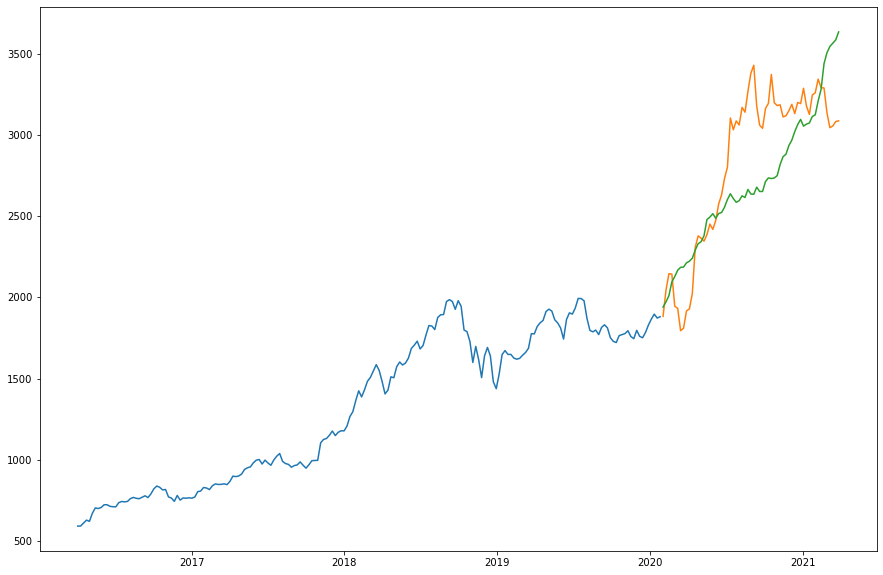

In [8]:
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
train, test = df_week[:200], df_week[200:]
plt.figure(figsize=(15, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pd.Series(inv_boxcox(fitted, -0.4) + stl.seasonal.shift(96)))

In [9]:
cut_stl = stl.seasonal.shift(48)
cut_stl = cut_stl[-61:]
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(df_week[-61:], inv_boxcox(fitted, -0.4) + cut_stl)

0.08550073843713811

In [10]:
from statsmodels.tsa.holtwinters import Holt

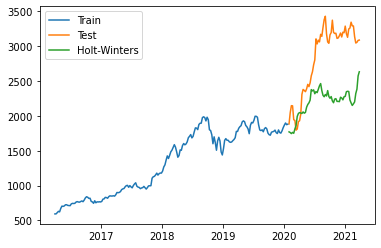

In [11]:
train, test = df_week[:200], df_week[200:]
model_hw = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
pred = model_hw.forecast(61).rename("Holt's linear trend")
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred + cut_stl, label='Holt-Winters')
plt.legend(loc='best')

In [12]:
mean_absolute_percentage_error(df_week[-61:], pred + cut_stl)

0.2113565728262838

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

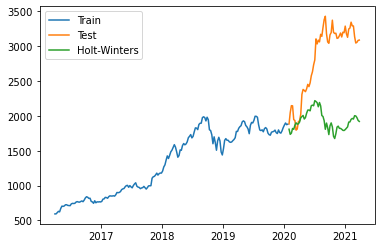

In [14]:
model_hw = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=96).fit()
pred = model_hw.predict(start=test.index[0], end=test.index[-1])
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

In [15]:
mean_absolute_percentage_error(df_week[-61:], pred)

0.2940485983563123